In [1]:
import json
import pandas as pd
import glob
import numpy as np
import networkx as nx
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, mapping
from scipy.spatial import Delaunay, KDTree
from ipyleaflet import Map, GeoJSON

In [2]:
ships = []
for fname in glob.glob('data/marinetraffic/*.json'):
    print (fname)
    with open(fname) as f:
        j = json.loads(f.read())
        ships += j['data']['rows']
print(len(ships))

data/marinetraffic/2018-09-29-X1Y1.json
data/marinetraffic/2018-09-29-X1Y0.json
data/marinetraffic/2018-09-29-X0Y1.json
data/marinetraffic/2018-09-29-X0Y0.json
7586


In [16]:
df = pd.DataFrame(ships)
#df[df.SHIPNAME.str.contains('MAERSK')]
container_ships = df[df.SHIPTYPE == '7'].loc[:, ['SHIPNAME', 'LON', 'LAT']].astype({'LON': float, 'LAT': float})
container_ships.head()
print(len(container_ships))

3523


In [17]:
container_ships.describe()

,LON,LAT
count,3523.000000,3523.000000
mean,16.393224,13.095442
std,84.154423,29.474920
min,-179.758800,-55.525720
25%,-36.756800,-9.082247
50%,4.448350,8.822746
75%,98.554110,39.613100
max,179.919100,74.527040


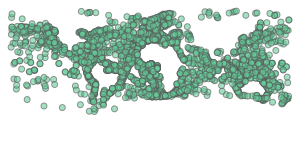

In [18]:
coords = container_ships.loc[:, ['LON', 'LAT']].astype(float).values
MultiPoint(coords)

In [24]:
coords[0]
help(Point)

Help on class Point in module shapely.geometry.point:

class Point(shapely.geometry.base.BaseGeometry)
 |  A zero dimensional feature
 |  
 |  A point has zero length and zero area.
 |  
 |  Attributes
 |  ----------
 |  x, y, z : float
 |      Coordinate values
 |  
 |  Example
 |  -------
 |    >>> p = Point(1.0, -1.0)
 |    >>> print(p)
 |    POINT (1.0000000000000000 -1.0000000000000000)
 |    >>> p.y
 |    -1.0
 |    >>> p.x
 |    1.0
 |  
 |  Method resolution order:
 |      Point
 |      shapely.geometry.base.BaseGeometry
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args)
 |      Parameters
 |      ----------
 |      There are 2 cases:
 |      
 |      1) 1 parameter: this must satisfy the numpy array protocol.
 |      2) 2 or more parameters: x, y, z : float
 |          Easting, northing, and elevation.
 |  
 |  array_interface(self)
 |      Provide the Numpy array protocol.
 |  
 |  svg(self, scale_factor=1.0, fill_color=None)
 |      Returns

Number of clusters: 777


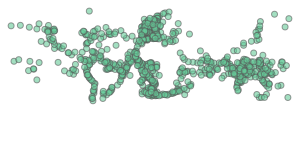

In [26]:
# Find cluster centers with DBSCAN (centers not in dataset)
kms_per_radian = 6371.0088
EPSILON_KM = 50.0
MIN_SAMPLES=2
epsilon = EPSILON_KM / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=MIN_SAMPLES, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
max_label = max(db.labels_)
clusters = [coords[db.labels_ == label] for label in range(max_label)]
clusters = [c for c in clusters if c.shape[0] > 0]
print('Number of clusters:', len(clusters))

# Find most central point in each cluster (points in dataset)

def get_centermost_point(cluster):
    centroid = MultiPoint(cluster).centroid
    centroid = (centroid.y, centroid.x)
    #print(centroid)
    #print(cluster[0])
    most_central = min(cluster, key=lambda point: great_circle((point[1], point[0]), centroid).m)
    return most_central

centers = [get_centermost_point(cluster) for cluster in clusters]
centers = np.array(centers).copy()

MultiPoint(centers)


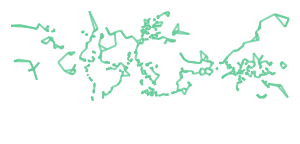

In [27]:
# Find neighbors approach (kd tree)
def get_neighbors(points):
    tree = KDTree(points)
    for i, point in enumerate(points):
        dists, js = tree.query(point, k=3)
        for dist, j in zip(dists, js):
            # drop self-match
            if dist > 0:
                yield point, points[j]

lines = [x for x in get_neighbors(centers)]

multiline = MultiLineString(lines)
multiline

In [28]:
# This is how you make a Leaflet map in Jupyter notebook (doesn't work in lab)
# Not used for anything here.
wroclaw_center = [51.114290, 17.033722]
m = Map(center=wroclaw_center, zoom=2)
routes = {'type': 'Feature', 'properties': {}, 'geometry': mapping(multiline)}
m.add_layer(routes)
"""
with open('data/wroclaw/locations.json') as f:
    data = json.load(f)

geo_json = GeoJSON(data=data)
m.add_layer(geo_json);
"""

with open('routes.json', 'w') as fo:
    fo.write(json.dumps(routes))
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[51.11429, 17.033722], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']), TileLayer(attribution='', max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size'], url='')), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'interpolation', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=2)